### Import Libraries
在這個步驟中，匯入sklearn、matplotlib、kmodes函式庫。

In [19]:
from sklearn import cluster, metrics, preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from kmodes.kprototypes import KPrototypes

cwd = os.getcwd()

### Open Dataset and Data review

#### 資料集介紹(Dataset Introduction):

Gender: 男性/女性

Age: 年齡

Height: 身高

Weight: 體重

family_history_with_overweight: 是否有過重家族史

FAVC: 是否常吃高卡路里食物

FCVC: 攝取蔬菜的頻繁程度

NCP: 一天吃幾餐

CAEC: 在每餐中間攝取其他食物的頻繁程度

SMOKE: 是否抽菸(溫馨提醒: 抽菸bad)

CH2O: 一天攝取多少水(公升)

SCC: 是否有在計算卡路里

FAF: 身體活動頻率

TUE: 使用科技產品的頻繁程度

CALC: 喝酒的頻繁程度

MTRANS: 使用的交通工具

NObeyesdad: 體態

---

在這個步驟裡，我們先將身高及體重處理成bmi減少特徵數量。

然後將資料列出來後，可以觀察到這個資料集有接近一半都是Categorical Variable。

接著將每種體態的人的數量都列出來，可以觀察到在這個資料集裡，每種體態的人的數量分布是比較均勻的。

代表如果執行分類算法，可能不太會有因為特定體態的人的資料集數量太少導致的分類錯誤

In [20]:
data_dir = os.path.join(cwd, 'data/')
data = pd.read_csv(os.path.join(data_dir, 'ObesityDataSet_raw_and_data_sinthetic.csv'))
data['bmi'] = 1.3 * data['Weight'] / (data['Height'] ** 2.5)
data = data.drop(columns=['Height','Weight'], axis=1)
data.head(10)

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,bmi
0,Female,21.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,24.907824
1,Female,21.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,25.557738
2,Male,23.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,23.027819
3,Male,27.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,26.018445
4,Male,22.0,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,27.616567
5,Male,29.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,Normal_Weight,20.626792
6,Female,23.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,0.0,Sometimes,Motorbike,Normal_Weight,25.946447
7,Male,22.0,no,no,2.0,3.0,Sometimes,no,2.0,no,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,20.003666
8,Male,24.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Frequently,Public_Transportation,Normal_Weight,19.682185
9,Male,22.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,no,Public_Transportation,Normal_Weight,22.784062


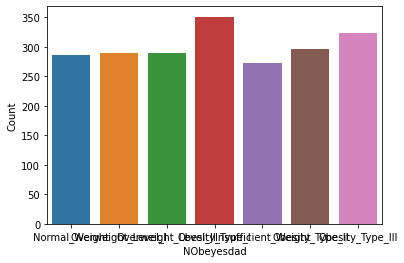

In [21]:
def count(data, column):
    sns.countplot(x=column, data=data)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

count(data, 'NObeyesdad')

### Data Preprocessing

我們首先把名稱較長的column重命名為較短名稱

然後將資料行(column)重新排序以便等等使用K-prototypes算法去分群。

In [22]:
# rename columns where column name is tooo long
data.rename(columns={'family_history_with_overweight': 'family_history'}, inplace=True)

# print possible values in categorical columns
print(f"""
Gender: {set(data['Gender'])}
family_history_with_overweight: {set(data['family_history'])}
FAVC: {set(data['FAVC'])}
CAEC: {set(data['CAEC'])}
SMOKE: {set(data['SMOKE'])}
SCC: {set(data['SCC'])}
CALC: {set(data['CALC'])}
MTRANS: {set(data['MTRANS'])}
NObeyesdad: {set(data['NObeyesdad'])}
""")
data.head()


Gender: {'Male', 'Female'}
family_history_with_overweight: {'yes', 'no'}
FAVC: {'yes', 'no'}
CAEC: {'Always', 'Sometimes', 'Frequently', 'no'}
SMOKE: {'yes', 'no'}
SCC: {'yes', 'no'}
CALC: {'Always', 'Sometimes', 'no', 'Frequently'}
MTRANS: {'Automobile', 'Motorbike', 'Walking', 'Public_Transportation', 'Bike'}
NObeyesdad: {'Obesity_Type_II', 'Overweight_Level_I', 'Insufficient_Weight', 'Overweight_Level_II', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_III'}



,Gender,Age,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,bmi
0,Female,21.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,24.907824
1,Female,21.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,25.557738
2,Male,23.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,23.027819
3,Male,27.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,26.018445
4,Male,22.0,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,27.616567


In [23]:
def onehot_encoder(data, columns):
    dummies = pd.get_dummies(data, columns=columns)
    return dummies

def label_encoder(data, columns):
    le = preprocessing.LabelEncoder()
    for column in columns:
        data[column] = le.fit_transform(data[column])
    return data

In [24]:
norm = data.copy()

#normalize data
#scaler = preprocessing.MinMaxScaler()
#norm[['Age', 'bmi', 'TUE', 'FAF', 'CH2O', 'NCP', 'FCVC']] = scaler.fit_transform(norm[['Age', 'bmi', 'TUE', 'FAF', 'CH2O', 'NCP', 'FCVC']])

# reorder
norm = norm.reindex(columns=[ 'Age', 'bmi', 'TUE', 'FAF', 'CH2O', 'NCP', 'FCVC', 'Gender', 'family_history', 'FAVC', 'CAEC','SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad',])

# drop target column
normWithoutTarget = norm.drop(columns=['NObeyesdad', 'bmi'])

#norm.head()
normWithoutTarget.head()

,Age,TUE,FAF,CH2O,NCP,FCVC,Gender,family_history,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
0,21.0,1.0,0.0,2.0,3.0,2.0,Female,yes,no,Sometimes,no,no,no,Public_Transportation
1,21.0,0.0,3.0,3.0,3.0,3.0,Female,yes,no,Sometimes,yes,yes,Sometimes,Public_Transportation
2,23.0,1.0,2.0,2.0,3.0,2.0,Male,yes,no,Sometimes,no,no,Frequently,Public_Transportation
3,27.0,0.0,2.0,2.0,3.0,3.0,Male,no,no,Sometimes,no,no,Frequently,Walking
4,22.0,0.0,0.0,2.0,1.0,2.0,Male,no,no,Sometimes,no,no,Sometimes,Public_Transportation


### Cluster Method 1: Kprototypes

K-Prototype 適用於含有 `numeric variable` 以及 `categorical variable` 的資料集，是K-modes算法以及K-means算法的集合形式。

針對數值屬性採用K-Means去做處理；針對分類屬性採用字元之間漢明距離去做處理，把K-Modes的結果乘以權重並加上K-Means之距離即為K-prototypes混和兩種屬性的方法。

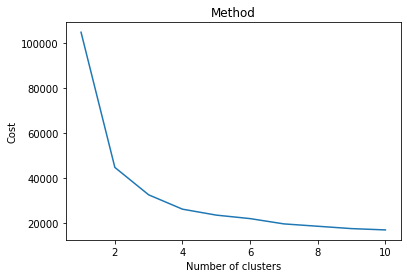

In [25]:
wcss = []
for i in range(1, 11):
    kproto = KPrototypes(n_clusters=i, init='Cao')
    clusters = kproto.fit(normWithoutTarget, categorical=list(range(6, 14)))
    wcss.append(kproto.cost_)
plt.plot(range(1, 11), wcss)
plt.title('Method')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.show()

### Cluster Method 2: Kmeans with one hot encoding

```
K-Means算法介紹:
    1. 設定初始簇的個數
    2. 使用歐基里德距離對資料進行分類，資料會與最接近的簇分為同一類
    3. 把簇內已分類的資料取x/y座標的平均值，並當作新的中心點
    4. 重新進行分類。
    5. 迭代直到不會有太大的變動為止。
```

在這個步驟中，我們使用K-Means搭配對分類欄位做One-Hot encoding 

In [26]:
kmeans_with_onehot = data.copy()

# one hot encoding
label_encoder(kmeans_with_onehot, ['NObeyesdad'])
kmeans_with_onehot = onehot_encoder(kmeans_with_onehot, ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS'])

# reorder colmun
kmeans_with_onehot = kmeans_with_onehot.reindex(columns=[
       'Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender_Female', 'Gender_Male', 'family_history_no',
       'family_history_yes', 'FAVC_no', 'FAVC_yes', 'CAEC_Always',
       'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_no', 'SMOKE_yes',
       'SCC_no', 'SCC_yes', 'CALC_Always', 'CALC_Frequently', 'CALC_Sometimes',
       'CALC_no', 'MTRANS_Automobile', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking', 'bmi', 'NObeyesdad'])
kmeans_with_onehot.head(10)

,Age,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,family_history_no,family_history_yes,...,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,bmi,NObeyesdad
0,21.0,2.0,3.0,2.0,0.0,1.0,1,0,0,1,...,0,0,1,0,0,0,1,0,24.907824,1
1,21.0,3.0,3.0,3.0,3.0,0.0,1,0,0,1,...,0,1,0,0,0,0,1,0,25.557738,1
2,23.0,2.0,3.0,2.0,2.0,1.0,0,1,0,1,...,1,0,0,0,0,0,1,0,23.027819,1
3,27.0,3.0,3.0,2.0,2.0,0.0,0,1,1,0,...,1,0,0,0,0,0,0,1,26.018445,5
4,22.0,2.0,1.0,2.0,0.0,0.0,0,1,1,0,...,0,1,0,0,0,0,1,0,27.616567,6
5,29.0,2.0,3.0,2.0,0.0,0.0,0,1,1,0,...,0,1,0,1,0,0,0,0,20.626792,1
6,23.0,3.0,3.0,2.0,1.0,0.0,1,0,0,1,...,0,1,0,0,0,1,0,0,25.946447,1
7,22.0,2.0,3.0,2.0,3.0,0.0,0,1,1,0,...,0,1,0,0,0,0,1,0,20.003666,1
8,24.0,3.0,3.0,2.0,1.0,1.0,0,1,0,1,...,1,0,0,0,0,0,1,0,19.682185,1
9,22.0,2.0,3.0,2.0,1.0,1.0,0,1,0,1,...,0,0,1,0,0,0,1,0,22.784062,1


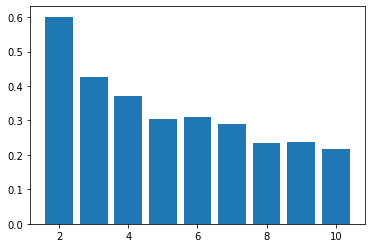

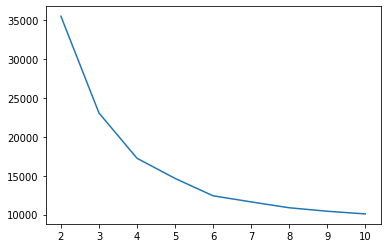

In [27]:
# Kmeans
x = kmeans_with_onehot.iloc[:, :29].values

wcss = []
perf = []
for k in range(2, 11):
    kmeans = cluster.KMeans(n_clusters=k).fit(x)
    labels = kmeans.labels_
    wcss.append(kmeans.inertia_)
    avg = metrics.silhouette_score(x, labels)
    perf.append(avg)

plt.bar(range(2, 11), perf)
plt.show()

plt.plot(range(2, 11), wcss)
plt.show()


### Cluster Method 3: Kmeans with label encoding

在這個步驟中，我們對分類欄位進行Label Encoding並使用K-Means作為分群的方法。

In [28]:
kmeans_with_label_encoding = data.copy()

# label encoding
label_encoder(kmeans_with_label_encoding, ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad'])

kmeans_with_label_encoding.head(10)

,Gender,Age,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,bmi
0,0,21.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,3,3,1,24.907824
1,0,21.0,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,2,3,1,25.557738
2,1,23.0,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,1,3,1,23.027819
3,1,27.0,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,1,4,5,26.018445
4,1,22.0,0,0,2.0,1.0,2,0,2.0,0,0.0,0.0,2,3,6,27.616567
5,1,29.0,0,1,2.0,3.0,2,0,2.0,0,0.0,0.0,2,0,1,20.626792
6,0,23.0,1,1,3.0,3.0,2,0,2.0,0,1.0,0.0,2,2,1,25.946447
7,1,22.0,0,0,2.0,3.0,2,0,2.0,0,3.0,0.0,2,3,1,20.003666
8,1,24.0,1,1,3.0,3.0,2,0,2.0,0,1.0,1.0,1,3,1,19.682185
9,1,22.0,1,1,2.0,3.0,2,0,2.0,0,1.0,1.0,3,3,1,22.784062


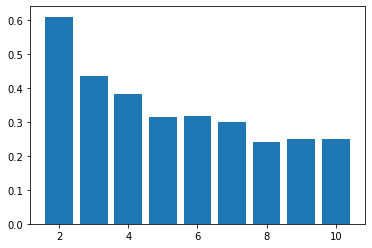

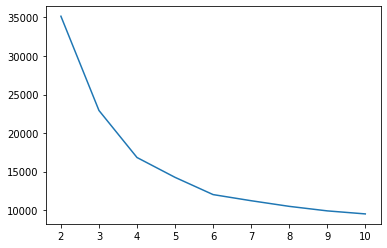

In [29]:
# Kmeans
x = kmeans_with_label_encoding.iloc[:, :14].values

wcss = []
perf = []
for k in range(2, 11):
    kmeans = cluster.KMeans(n_clusters=k).fit(x)
    labels = kmeans.labels_
    wcss.append(kmeans.inertia_)
    avg = metrics.silhouette_score(x, labels)
    perf.append(avg)

plt.bar(range(2, 11), perf)
plt.show()

plt.plot(range(2, 11), wcss)
plt.show()


### 結論:

可以觀察到，不管是使用One-hot encoding或Label Encoding，K-means在k=2~10中給出的wcss圖都找不太到elbow method中的彎折點，也就是說這種分群方法並不適合當前資料集。

相較於K-Means+One-hot encoding/Label Encoding，在K-Prototype算法中，可以比較清楚(相對於K-Means+One-hot encoding/Label Encoding)看到在k=2的時候有彎折點的出現。

故得出了一個結論:

如果你要分群的資料集有很多**分類欄位**，那比起使用K-Means去做分群，可能使用K-Prototype甚至K-Modes會比較適合這種資料集。

### 參考:

https://blog.csdn.net/jerry81333/article/details/74285284